In [2]:
import pathlib
import warnings
import warnings
warnings.filterwarnings('ignore')
import os

import sys
sys.path.append('../code/')
import pm_model_func as pmf

# Third-party
import astropy.coordinates as coord
import astropy.table as at
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from numpy.lib.recfunctions import stack_arrays
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d, UnivariateSpline
from scipy.ndimage.filters import gaussian_filter

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData
from scipy.stats import binned_statistic

import arviz as az
import pymc3 as pm
import seaborn as sns
from tqdm import trange
from pymc3 import *
import theano.tensor as tt
import pymc3_ext as pmx
from patsy import dmatrix

from ugali.utils import stats

In [3]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=20, labelsize=20)

In [15]:
fn = '../data/sample_outputs/trace0.netcdf'
d = az.from_netcdf(fn)

In [24]:
np.apply_over_axes(np.mean, a=d.posterior.ln_std_pm_stream, axes=[0,1]).reshape(2)

array([-3.50970873, -3.6540691 ])

In [28]:
gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')

stream_mask = gaia.gi_cmd_mask
g = gaia[(stream_mask)]# & (gaia.g_0 < 18)]

dist = g.get_distance(min_parallax=1e-3*u.mas)
c = g.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1 = stream_coord.phi1.degree
phi2 = stream_coord.phi2.degree
pm1 = stream_coord.pm_phi1_cosphi2
pm2 = stream_coord.pm_phi2

after = GaiaData('../data/sorted_pm_member_prob_all_stars_8comp.fits')

g_sorted, obs_pm_all, obs_pm_cov_all, phi1_stream_all, phi2_stream_all, bkg_ind = pmf.pre_model(gaia, g, after)
ln_bg_prob_all = after.pm_ln_bkg_prob.astype('float64')
n = len(phi1_stream_all)

In [17]:
%%time
phi2_means1 = np.apply_over_axes(stats.peak_interval, a=d.posterior.mean_phi2_stream, axes=[0,1])

phi2_means_peak = phi2_means1[0,:]
phi2_means_hilo = xmod_interval[1,:]

CPU times: user 5 µs, sys: 24 µs, total: 29 µs
Wall time: 31.9 µs


ValueError: Too few elements for interval calculation

In [29]:
phi2_means = np.apply_over_axes(np.mean, a=d.posterior.mean_phi2_stream, axes=[0,1])
phi2_stds = np.apply_over_axes(np.std, a=d.posterior.mean_phi2_stream, axes=[0,1])

width_means = np.apply_over_axes(np.mean, a=d.posterior.std_phi2_stream, axes=[0,1])
width_stds = np.apply_over_axes(np.std, a=d.posterior.std_phi2_stream, axes=[0,1])

pm1_means = np.apply_over_axes(np.mean, a=d.posterior.mean_pm_stream[:, :, :,0], axes=[0,1])
pm1_stds = np.apply_over_axes(np.std, a=d.posterior.mean_pm_stream[:, :, :,0], axes=[0,1])

pm2_means = np.apply_over_axes(np.mean, a=d.posterior.mean_pm_stream[:, :, :,1], axes=[0,1])
pm2_stds = np.apply_over_axes(np.std, a=d.posterior.mean_pm_stream[:, :, :,1], axes=[0,1])

spur_track_means = np.apply_over_axes(np.mean, a=d.posterior.mean_spur_track, axes=[0,1])

In [30]:
phi2_means = phi2_means.reshape((d.posterior.mean_phi2_stream.shape[2],))
phi2_stds = phi2_stds.reshape((d.posterior.mean_phi2_stream.shape[2]))

width_means = width_means.reshape((d.posterior.std_phi2_stream.shape[2],))
width_stds = width_stds.reshape((d.posterior.std_phi2_stream.shape[2]))

pm1_means = pm1_means.reshape((d.posterior.mean_pm_stream.shape[2],))
pm1_stds = pm1_stds.reshape((d.posterior.mean_phi2_stream.shape[2]))

pm2_means = pm2_means.reshape((d.posterior.mean_pm_stream.shape[2],))
pm2_stds = pm2_stds.reshape((d.posterior.mean_pm_stream.shape[2]))

spur_track_means = spur_track_means.reshape((d.posterior.mean_spur_track.shape[2]))

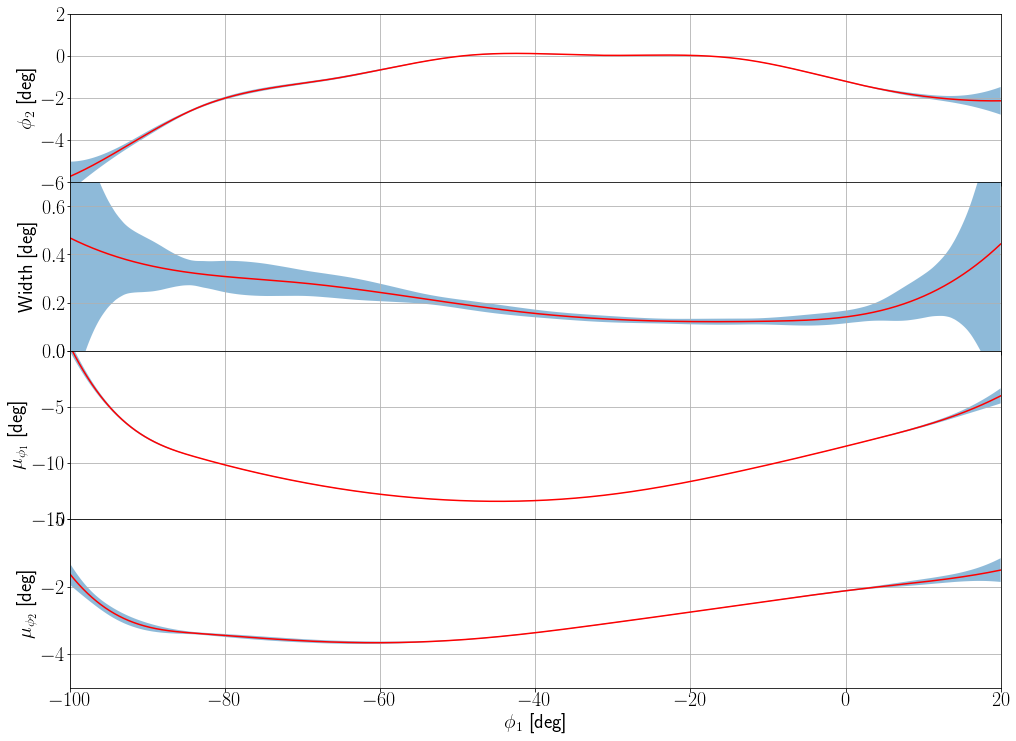

In [31]:
phi1_stream = phi1_stream_all[bkg_ind]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(14, 10), sharex=True)

ax1.plot(phi1_stream.reshape(386801), phi2_means, c = 'r')
ax1.fill_between(phi1_stream.reshape(386801), phi2_means-phi2_stds, phi2_means+phi2_stds, alpha=0.5)
ax1.set_ylabel(r'$\phi_2$ [deg]')
ax1.set_xlim(-100, 20); ax1.set_ylim(-6,2)
ax1.grid()

ax2.plot(phi1_stream.reshape(386801), width_means, c = 'r')
ax2.fill_between(phi1_stream.reshape(386801), width_means-phi2_stds, width_means+phi2_stds, alpha=0.5)
ax2.set_ylabel(r'Width [deg]')
ax2.set_xlim(-100, 20); ax2.set_ylim(0,0.7)
ax2.grid()

ax3.plot(phi1_stream.reshape(386801), pm1_means, c = 'r')
ax3.fill_between(phi1_stream.reshape(386801), pm1_means-pm1_stds, pm1_means+pm1_stds, alpha=0.5)
ax3.set_ylabel(r'$\mu_{\phi_1}$ [deg]')
ax3.set_xlim(-100, 20); ax3.set_ylim(-15,0)
ax3.grid()

ax4.plot(phi1_stream.reshape(386801), pm2_means, c = 'r')
ax4.fill_between(phi1_stream.reshape(386801), pm2_means-pm2_stds, pm2_means+pm2_stds, alpha=0.5)
ax4.set_xlabel(r'$\phi_1$ [deg]'); ax4.set_ylabel(r'$\mu_{\phi_2}$ [deg]')
ax4.set_xlim(-100, 20); ax4.set_ylim(-5,0)
ax4.grid()

fig.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0)

In [32]:
spline_pm1 = UnivariateSpline(phi1_stream.reshape(len(phi1_stream))[::10], pm1_means[::10], s=0)
spline_pm2 = UnivariateSpline(phi1_stream.reshape(len(phi1_stream))[::10], pm2_means[::10], s=0)
spline_phi2 = UnivariateSpline(phi1_stream.reshape(len(phi1_stream))[::10], phi2_means[::10], s=0)
spline_width = UnivariateSpline(phi1_stream.reshape(len(phi1_stream))[::10], width_means[::10], s=0)

In [33]:
alpha = np.mean(d.posterior.alpha).data
beta = np.mean(d.posterior.beta).data

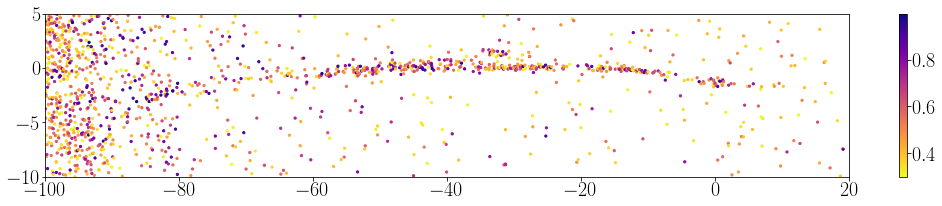

In [34]:
ln_std_pm_stream_means = np.apply_over_axes(np.mean, a=d.posterior.ln_std_pm_stream, axes=[0,1])
std_pm_stream_means = np.exp(ln_std_pm_stream_means).reshape(2)
cov_pm_stream_means = np.diag(std_pm_stream_means**2)
full_cov_all = obs_pm_cov_all + cov_pm_stream_means

a_all = full_cov_all[:, 0, 0]
b_all = c_all = full_cov_all[:, 0, 1]
d_all = full_cov_all[:, 1, 1]
det_all = a_all*d_all - b_all*c_all

diff_all=obs_pm_all - np.vstack([spline_pm1(phi1_stream_all).reshape(n), spline_pm2(phi1_stream_all).reshape(n)]).T
numer_all = (
    d_all * diff_all[:, 0] ** 2 
    + a_all * diff_all[:, 1] ** 2
    - (b_all + c_all) * diff_all[:, 0] * diff_all[:, 1]
)
quad_all = numer_all / det_all
loglike_fg_pm_all = -0.5 * (quad_all + np.log(det_all) + 2 * np.log(2*np.pi))

ll_fg_pm_all = np.log(alpha) + loglike_fg_pm_all
ll_bg_full_all = np.log(1 - alpha) + ln_bg_prob_all

post_member_prob_pm_all = np.exp(ll_fg_pm_all - np.logaddexp(ll_fg_pm_all, ll_bg_full_all))
high_prob_pm = [post_member_prob_pm_all > 0.3]

plt.figure(figsize=(18,3))
plt.scatter(phi1_stream_all[high_prob_pm], phi2_stream_all[high_prob_pm], c= post_member_prob_pm_all[high_prob_pm], 
            s=5, cmap = 'plasma_r')
plt.colorbar()
plt.xlim(-100, 20)
plt.ylim(-10, 5)
plt.show()

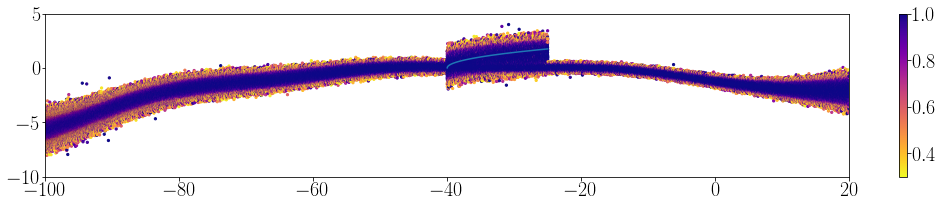

In [35]:
std_phi2_stream_all = spline_width(phi1_stream_all).reshape(n)
var_phi2_stream_all = std_phi2_stream_all**2

diff_phi2_all = phi2_stream_all.reshape(n) - spline_phi2(phi1_stream_all).reshape(n)
loglike_fg_phi2_all = -0.5 * (np.log(var_phi2_stream_all) + ((diff_phi2_all**2)/var_phi2_stream_all)
                              + np.log(2*np.pi))
ll_fg_phi2_all = loglike_fg_phi2_all + np.log(beta)

spur_sel_all = np.where((phi1_stream_all > -40) & (phi1_stream_all < -25))[0]
phi1_spur_all, phi2_spur_all = phi1_stream_all[spur_sel_all], phi2_stream_all[spur_sel_all]
phi1_spur_all, phi2_spur_all = phi1_spur_all.reshape(len(spur_sel_all)), phi2_spur_all.reshape(len(spur_sel_all))
left_all = phi1_stream_all[np.where((phi1_stream_all < -40) & (phi1_stream_all > -101))[0]]
right_all = phi1_stream_all[np.where((phi1_stream_all > -25) & (phi1_stream_all < 21))[0]]

phi1_spur = phi1_stream[np.where((phi1_stream > -40) & (phi1_stream < -25))[0]]
spline_spur = UnivariateSpline(phi1_spur.reshape(len(phi1_spur))[::5], spur_track_means[::5], s=0)

left_all = -np.inf*np.exp(np.ones(left_all.shape[0]))
right_all = -np.inf*np.exp(np.ones(right_all.shape[0]))

std_phi2_spur = np.mean(d.posterior.std_phi2_spur).data
var_phi2_spur = std_phi2_spur**2

diff_spur_all = phi2_spur_all - spline_spur(phi1_spur_all)

loglike_fg_spur_i_all = -0.5 * (np.log(var_phi2_spur) + ((diff_spur_all**2)/var_phi2_spur) + np.log(2*np.pi))
loglike_fg_spur_all = np.concatenate([left_all, loglike_fg_spur_i_all, right_all])
loglike_fg_spur_all = loglike_fg_spur_all.reshape(loglike_fg_phi2_all.shape)

ll_fg_phi2_spur_all = np.log(1-beta) + loglike_fg_spur_all

ll_fg_phi2_total_all = np.logaddexp(loglike_fg_phi2_all, loglike_fg_spur_all)

ll_bg_full_all = np.log(1 - alpha) + ln_bg_prob_all

post_member_prob_track_all = np.exp(ll_fg_phi2_total_all - np.logaddexp(ll_fg_phi2_total_all, ll_bg_full_all))
high_prob_phi2 = [post_member_prob_track_all > 0.3]

plt.figure(figsize=(18,3))
plt.scatter(phi1_stream_all[high_prob_phi2],phi2_stream_all[high_prob_phi2],c=
            post_member_prob_track_all[high_prob_phi2], 
            s=5, cmap = 'plasma_r')
plt.plot(phi1_spur, 0.45*np.sqrt(phi1_spur+40))
plt.colorbar()
plt.xlim(-100, 20)
plt.ylim(-10, 5)
plt.show()

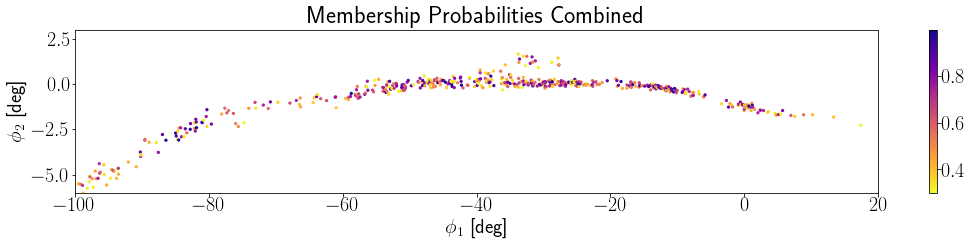

In [28]:
ll_fg = ll_fg_phi2_total_all + ll_fg_pm_all
ll_bg = np.log(1 - alpha) + ln_bg_prob_all

post_member_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
high_prob = [post_member_prob > 0.3]

plt.figure(figsize=(18,3))
plt.scatter(phi1_stream_all[high_prob], phi2_stream_all[high_prob], c = post_member_prob[high_prob], 
            s=5, cmap = 'plasma_r')
plt.colorbar()
plt.xlim(-100, 20); plt.ylim(-6, 3); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')
plt.show()

# Spur Model Output

In [3]:
gaia = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
gaia0 = gaia[(gaia.phi1 > -45) & (gaia.phi1 < -27)]

stream_mask = gaia0.gi_cmd_mask
g0 = gaia0[(stream_mask)]# & (gaia.g_0 < 18)

dist = g0.get_distance(min_parallax=1e-3*u.mas)
c = g0.get_skycoord(distance=dist)
stream_coord = c.transform_to(gc.GD1)
phi1 = stream_coord.phi1.degree
phi2 = stream_coord.phi2.degree
pm1 = stream_coord.pm_phi1_cosphi2
pm2 = stream_coord.pm_phi2

after0 = GaiaData('../data/sorted_pm_member_prob_all_stars_8comp.fits')
after0 = after0[(after0.phi1 > -45) & (after0.phi1 < -27)]

g_sorted0, obs_pm_all0, obs_pm_cov_all0, phi1_stream_all0, phi2_stream_all0, bkg_ind0=pmf.pre_model(gaia0,g0,after0)
ln_bg_prob_all0 = after0.pm_ln_bkg_prob.astype('float64')
ln_bg_prob0 = ln_bg_prob_all0[bkg_ind0]

In [4]:
phi1_stream0 = phi1_stream_all0[bkg_ind0]

In [5]:
fn_spur = '../data/sample_outputs/spur_trace0.netcdf'
d_spur = az.from_netcdf(fn_spur)

In [6]:
alpha = np.mean(d_spur.posterior.alpha).data
beta = np.mean(d_spur.posterior.beta).data

spur_track_means0 = np.apply_over_axes(np.mean, a=d_spur.posterior.mean_spur_track, axes=[0,1])
spur_track_stds0 = np.apply_over_axes(np.std, a=d_spur.posterior.mean_spur_track, axes=[0,1])

pm1_spur = stats.peak_interval(d_spur.posterior.mean_pm_spur[:, :, 0].data.reshape(1000))
pm1_spur_peak = pm1_spur[0]
pm1_spur_hilo = pm1_spur[1]

pm2_spur = stats.peak_interval(d_spur.posterior.mean_pm_spur[:, :, 1].data.reshape(1000))
pm2_spur_peak = pm2_spur[0]
pm2_spur_hilo = pm2_spur[1]

pm1_stream = stats.peak_interval(d_spur.posterior.mean_pm_stream[:, :, 0].data.reshape(1000))
pm1_stream_peak = pm1_stream[0]
pm1_stream_hilo = pm1_stream[1]

pm2_stream = stats.peak_interval(d_spur.posterior.mean_pm_stream[:, :, 1].data.reshape(1000))
pm2_stream_peak = pm2_stream[0]
pm2_stream_hilo = pm2_stream[1]


ln_std_pm1_stream = stats.peak_interval(d_spur.posterior.ln_std_pm_stream[:, :, 0].data.reshape(1000))
ln_std_pm1_stream_peak = ln_std_pm1_stream[0]
ln_std_pm1_stream_hilo = ln_std_pm1_stream[1]

ln_std_pm2_stream = stats.peak_interval(d_spur.posterior.ln_std_pm_stream[:, :, 1].data.reshape(1000))
ln_std_pm2_stream_peak = ln_std_pm2_stream[0]
ln_std_pm2_stream_hilo = ln_std_pm2_stream[1]

mean_phi2_stream = stats.peak_interval(d_spur.posterior.mean_phi2_stream.data.reshape(1000))
mean_phi2_stream_peak = mean_phi2_stream[0]
mean_phi2_stream_hilo = mean_phi2_stream[1]

std_phi2_stream = stats.peak_interval(d_spur.posterior.std_phi2_stream.data.reshape(1000))
std_phi2_stream_peak = std_phi2_stream[0]
std_phi2_stream_hilo = std_phi2_stream[1]

In [7]:
print('pm spur: ({}, {})'.format(pm1_spur_peak, pm2_spur_peak))
print('1sigma confidence intervals: {}, {}'.format(pm1_spur_hilo, pm2_spur_hilo))
print('----------------')
print('pm stream: ({}, {})'.format(pm1_stream_peak, pm2_stream_peak))
print('1sigma confidence intervals: {}, {}'.format(pm1_stream_hilo, pm2_stream_hilo))

pm spur: (-13.088511709719306, -3.1996239627117613)
1sigma confidence intervals: [-13.10935925796026, -13.055759637035424], [-3.2407273444669302, -3.171146663020376]
----------------
pm stream: (-13.023623966622202, -3.213041024650175)
1sigma confidence intervals: [-13.05785191116969, -12.99563747512408], [-3.237137365277765, -3.190581782417368]


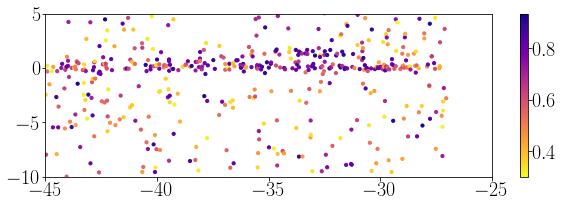

In [8]:
ln_std_pm_stream_means = [ln_std_pm1_stream_peak, ln_std_pm1_stream_peak]
std_pm_stream_means = np.exp(ln_std_pm_stream_means)
cov_pm_stream_means = np.diag(std_pm_stream_means**2)
full_cov_all = obs_pm_cov_all0 + cov_pm_stream_means

a_all = full_cov_all[:, 0, 0]
b_all = c_all = full_cov_all[:, 0, 1]
d_all = full_cov_all[:, 1, 1]
det_all = a_all*d_all - b_all*c_all

diff_all=obs_pm_all0 - [pm1_stream_peak, pm2_stream_peak]
numer_all = (
    d_all * diff_all[:, 0] ** 2 
    + a_all * diff_all[:, 1] ** 2
    - (b_all + c_all) * diff_all[:, 0] * diff_all[:, 1]
)
quad_all = numer_all / det_all
loglike_fg_pm_all = -0.5 * (quad_all + np.log(det_all) + 2 * np.log(2*np.pi))

ll_fg_pm_all = np.log(alpha) + loglike_fg_pm_all
ll_bg_full_all0 = np.log(1 - alpha) + ln_bg_prob_all0

post_member_prob_pm_all0 = np.exp(ll_fg_pm_all - np.logaddexp(ll_fg_pm_all, ll_bg_full_all0))
high_prob_pm = [post_member_prob_pm_all0 > 0.3]

plt.figure(figsize=(10,3))
plt.scatter(phi1_stream_all0[high_prob_pm],phi2_stream_all0[high_prob_pm],c=post_member_prob_pm_all0[high_prob_pm], 
            s=10, cmap = 'plasma_r')
plt.colorbar()
plt.xlim(-45, -25)
plt.ylim(-10, 5)
plt.show()

#post_member_prob3 = np.exp(
#            res['ll_fg_full'] 
#            - np.logaddexp(res['ll_fg_full'], res['ll_bg_full']))

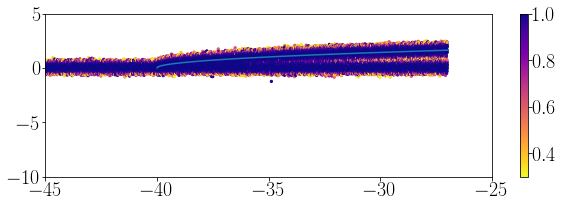

In [12]:
var_phi2_stream = std_phi2_stream_peak**2

diff_phi2_all = phi2_stream_all0 - mean_phi2_stream_peak
loglike_fg_phi2_all = -0.5 * (np.log(var_phi2_stream) + ((diff_phi2_all**2)/var_phi2_stream) + np.log(2*np.pi))
loglike_fg_phi2_all = loglike_fg_phi2_all.reshape(loglike_fg_pm_all.shape)

spur_sel_all0 = np.where((phi1_stream_all0 > -40) & (phi1_stream_all0 < -25))[0]
phi1_spur_all0, phi2_spur_all0 = phi1_stream_all0[spur_sel_all0], phi2_stream_all0[spur_sel_all0]
phi1_spur_all0,phi2_spur_all0=phi1_spur_all0.reshape(len(spur_sel_all0)),phi2_spur_all0.reshape(len(spur_sel_all0))
left_all = phi1_stream_all0[np.where((phi1_stream_all0 < -40) & (phi1_stream_all0 > -101))[0]]
right_all = phi1_stream_all0[np.where((phi1_stream_all0 > -25) & (phi1_stream_all0 < 21))[0]]

phi1_spur0 = phi1_stream0[np.where((phi1_stream0 > -40) & (phi1_stream0 < -25))[0]]
spline_spur0 = UnivariateSpline(phi1_spur0.reshape(len(phi1_spur0))[::5],
                                spur_track_means0.reshape(17538)[::5], s=0)

left_all = -np.inf*np.exp(np.ones(left_all.shape[0]))
right_all = -np.inf*np.exp(np.ones(right_all.shape[0]))

std_phi2_spur = np.mean(d_spur.posterior.std_phi2_spur).data
var_phi2_spur = std_phi2_spur**2

diff_spur_all = phi2_spur_all0 - spline_spur0(phi1_spur_all0)

loglike_fg_spur_i_all = -0.5 * (np.log(var_phi2_spur) + ((diff_spur_all**2)/var_phi2_spur) + np.log(2*np.pi))
loglike_fg_spur_all = np.concatenate([left_all, loglike_fg_spur_i_all, right_all])
loglike_fg_spur_all = loglike_fg_spur_all.reshape(loglike_fg_phi2_all.shape)

ll_fg_phi2_spur_all = np.log(1-beta) + loglike_fg_spur_all

ll_fg_phi2_total_all = np.logaddexp(loglike_fg_phi2_all, loglike_fg_spur_all)

ll_bg_full_all0 = np.log(1 - alpha) + ln_bg_prob_all0

post_member_prob_track_all = np.exp(ll_fg_phi2_total_all - np.logaddexp(ll_fg_phi2_total_all, ll_bg_full_all0))
high_prob_phi2 = [post_member_prob_track_all > 0.3]

plt.figure(figsize=(10,3))
plt.scatter(phi1_stream_all0[high_prob_phi2],phi2_stream_all0[high_prob_phi2],c=
            post_member_prob_track_all[high_prob_phi2], 
            s=5, cmap = 'plasma_r')
plt.plot(phi1_spur0, 0.45*np.sqrt(phi1_spur0+40))
plt.colorbar()
plt.xlim(-45, -25)
plt.ylim(-10, 5)
plt.show()

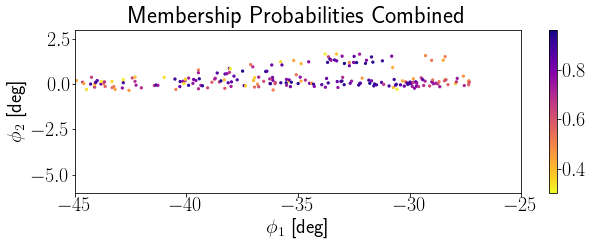

In [13]:
ll_fg = ll_fg_phi2_total_all + ll_fg_pm_all
ll_bg = np.log(1 - alpha) + ln_bg_prob_all0

post_member_prob = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
high_prob = [post_member_prob > 0.3]

plt.figure(figsize=(10,3))
plt.scatter(phi1_stream_all0[high_prob], phi2_stream_all0[high_prob], c = post_member_prob[high_prob], 
            s=5, cmap = 'plasma_r')
plt.colorbar()
plt.xlim(-45, -25); plt.ylim(-6, 3); 
plt.xlabel(r'$\phi_1$ [deg]'); plt.ylabel(r'$\phi_2$ [deg]')
plt.title(r'Membership Probabilities Combined')
plt.show()

In [14]:
post_member_prob_all = np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))

ll_fg_spur = ll_fg_phi2_spur_all + ll_fg_pm_all
post_member_prob_spur = np.exp(ll_fg_spur - np.logaddexp(ll_fg_spur, ll_bg))

Text(0, 0.5, '$\\mu_{\\phi_2}$')

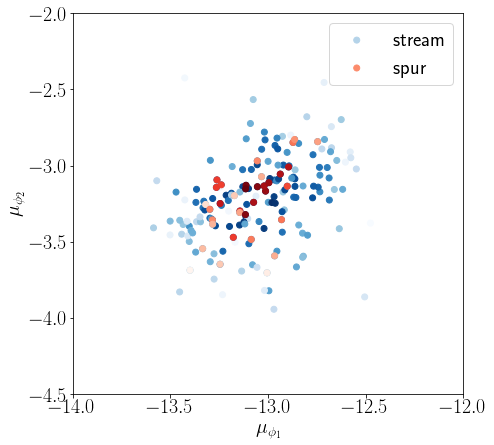

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
high_prob_all = post_member_prob_all[post_member_prob_all>0.5]
high_prob_spur = post_member_prob_spur[post_member_prob_spur>0.5]

e1 = mpl.patches.Ellipse((pm1_spur_peak, pm2_spur_peak), width = pm1_spur_hilo[1] - pm1_spur_hilo[0],
                   height = pm2_spur_hilo[1] - pm2_spur_hilo[0], facecolor='red', edgecolor = 'red', lw=10)

e2 = mpl.patches.Ellipse((pm1_stream_peak, pm2_stream_peak), width = pm1_stream_hilo[1] - pm1_stream_hilo[0],
                   height = pm2_stream_hilo[1] - pm2_stream_hilo[0], facecolor='blue', edgecolor='blue', lw=10)
#ax.add_patch(e1)
#ax.add_patch(e2)


ax.scatter(obs_pm_all0[:,0][post_member_prob_all>0.5], obs_pm_all0[:,1][post_member_prob_all>0.5], 
            c=high_prob_all, cmap='Blues', label='stream')


ax.scatter(obs_pm_all0[:,0][post_member_prob_spur>0.5], obs_pm_all0[:,1][post_member_prob_spur>0.5], 
            c=high_prob_spur, cmap='Reds', label='spur')
ax.legend()
ax.set_xlim(-14, -12)
ax.set_ylim(-4.5,-2)
ax.set_xlabel(r'$\mu_{\phi_1}$')
ax.set_ylabel(r'$\mu_{\phi_2}$')

(-3.5, -3.0)

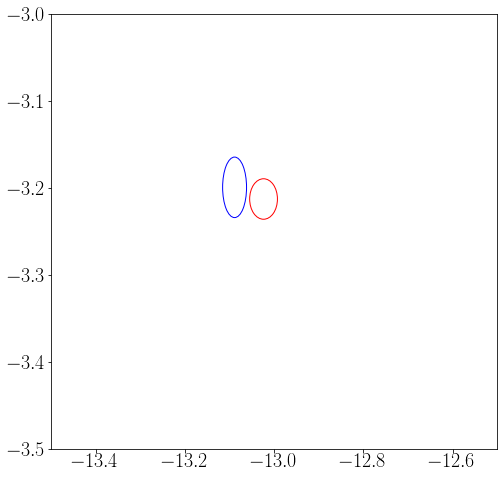

In [66]:
e1 = mpl.patches.Ellipse((pm1_spur_peak, pm2_spur_peak), width = pm1_spur_hilo[1] - pm1_spur_hilo[0],
                   height = pm2_spur_hilo[1] - pm2_spur_hilo[0], facecolor='none', edgecolor = 'blue')

e2 = mpl.patches.Ellipse((pm1_stream_peak, pm2_stream_peak), width = pm1_stream_hilo[1] - pm1_stream_hilo[0],
                   height = pm2_stream_hilo[1] - pm2_stream_hilo[0], facecolor='none', edgecolor='red')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.add_patch(e1)
ax.add_patch(e2)
ax.set_xlim(-13.5, -12.5)
ax.set_ylim(-3.5, -3)